In [1]:
import config

import matplotlib.pyplot as plt
import numpy as np
#import torch
import random

import cv2

import onnx
import onnxruntime

# Save Folders

In [2]:
#

# Check ONNX Models

In [3]:
detector_name = './onnx_detection_models/w8a8b8__bed_detector___aimet__fixed_point__qcdq__CPU.onnx'
detector = onnx.load(detector_name)
onnx.checker.check_model(detector)

# Functions to Plot Predictions

In [4]:
def iou(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = np.maximum(box1_x1, box2_x1)
    y1 = np.maximum(box1_y1, box2_y1)
    x2 = np.minimum(box1_x2, box2_x2)
    y2 = np.minimum(box1_y2, box2_y2)

    intersection = np.clip((x2 - x1), a_min=0, a_max=None) * np.clip((y2 - y1), a_min=0, a_max=None)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def non_max_supression(bboxes, 
                       iou_threshold=config.IOU_THRESHOLD, 
                       score_threshold=config.SCORE_THRESHOLD, 
                       box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        score_threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > score_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou(
                np.array(chosen_box[:4]),
                np.array(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


# ______________________________________________________________ #
# ____________________      Pred Boxes      ____________________ #
# ______________________________________________________________ #
def numpy_get_best_box_and_class(out):
    
    conf_1 = out[..., 4:5]
    conf_2 = out[..., 9:10]
    confs = np.concatenate((conf_1, conf_2), axis=-1)
    idx = np.argmax(confs, keepdims=True, axis=-1)
    
    best_boxes = idx*out[..., 5:10] + (1-idx)*out[..., 0:5]
    
    class_idx = np.argmax(out[..., 10:12], keepdims=True, axis=-1)
    
    best_out = np.concatenate((best_boxes, class_idx), axis=-1)

    return best_out

def get_bboxes_from_model_out(model_out, 
                              iou_threshold=config.IOU_THRESHOLD, 
                              score_threshold=config.SCORE_THRESHOLD):

    model_out = numpy_get_best_box_and_class(model_out)
    
    c2b_mtx = np.zeros((config.S, config.S, 2))
    for j in range(config.S):
        for i in range(config.S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    out_xy = model_out[..., :2]
    out_rest = model_out[..., 2:]

    c2b_xy = (c2b_mtx+out_xy)/config.S
    out = np.concatenate((c2b_xy, out_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_flat = np.reshape(out, (config.S*config.S, 5+1)) # Replace 5+C by 5+1, as we filtered best class before (get_best_box_and_class)
    bboxes_list = [bbox for bbox in bboxes_flat.tolist()]

    nms_pred_bboxes = non_max_supression(
        bboxes_list,
        iou_threshold=iou_threshold, 
        score_threshold=score_threshold, 
        box_format="midpoint")

    return nms_pred_bboxes


# ______________________________________________________________ #
# ____________________        Plots         ____________________ #
# ____________________ True & Pred Boxes    ____________________ #
# ______________________________________________________________ #
def plot_grid(img):
    '''
    Plot grid on top of the picture
    '''
      
    cell_size = int(config.IMG_W / config.S)
    
    # Draw horizontal lines
    for i in range(1, config.S):
        cv2.line(img, (0, cell_size*i), (config.IMG_W-1, cell_size*i), config.GRID_COLOR, 1)
    # Draw vertical lines
    for j in range(1, config.S):
        cv2.line(img, (cell_size*j, 0), (cell_size*j, config.IMG_H-1), config.GRID_COLOR, 1)
        
    return img

    
def plot_predicted_img(img, model_out, score_thres=None, grid=False):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - model_out: [xcell, ycell, w, h, score, smoke, fire], tensor (7, 7, 12)
        - grid: plot grid over the image

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    # NEVER remove copy() or use np.ascontiguousarray()
    img = np.transpose(img, (1, 2, 0)) * 256
    img = img.astype(np.uint8).copy()   
       
    if grid == True:
        img = plot_grid(img)
    
    if score_thres is not None:
        bboxes = get_bboxes_from_model_out(
            model_out,
            score_threshold=score_thres)
    else:
        bboxes = get_bboxes_from_model_out(model_out)
        
    for box_elem in bboxes:
        print(box_elem)

    for xc, yc, w, h, score, class_id in bboxes:
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*config.IMG_W
        np.clip(box[0], 0, None)
        box[1] = box[1]*config.IMG_H
        np.clip(box[1], 0, None)
        box[2] = box[2]*config.IMG_W - 1 # avoid out of limits due to rounding
        box[3] = box[3]*config.IMG_H - 1 # avoid out of limits due to rounding
        box = box.round().astype(np.int32).tolist()
        
        class_id = int(class_id)
        name = config.CLASSES[class_id]
        color = config.BBOX_COLORS[name]
        name += str(f' {score:.3f}')
        
        cv2.rectangle(img, box[:2], box[2:], color, 1) 
        if box[1] < 30:
            if class_id == 0:
                cv2.rectangle(img, [box[0], box[1]+15], [box[0]+105, box[1]], color, -1) 
            else:
                cv2.rectangle(img, [box[0], box[1]+15], [box[0]+80, box[1]], color, -1) 
            cv2.putText(img,name,(box[0], box[1] + 12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size
        else:
            if class_id == 0:
                cv2.rectangle(img, [box[0], box[1]-20], [box[0]+105, box[1]], color, -1) 
            else:
                cv2.rectangle(img, [box[0], box[1]-20], [box[0]+80, box[1]], color, -1) 
            cv2.putText(img,name,(box[0], box[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size

    return img

# ______________________________________________________________ #
# _________________ ONNX Prediction Function  __________________ #
# ______________________________________________________________ #
def onnx_predict(
    img,
    detect_session,
):
    '''
    Function to perform 1 prediction
    
    '''
    
    detect_inputs = {detect_session.get_inputs()[0].name: img}
    out = detect_session.run(None, detect_inputs)
    
    # Numpy
    out = np.transpose(out[0], (0, 2, 3, 1))
        
    # Remove batch dim, although it makes no difference for get_bboxes_from_model_out 
    out = out[0]   
    
    return out

# ONNX Session

In [5]:
detect_session = onnxruntime.InferenceSession(detector_name, providers=["CPUExecutionProvider"])

# 1 Pic Inference

In [6]:
img_file = './WEB10437.jpg'
#img_file = './WEB11371.jpg'
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
img = cv2.resize(img, (config.IMG_W, config.IMG_H), interpolation = cv2.INTER_NEAREST)
#img = (img / 256.)

[]

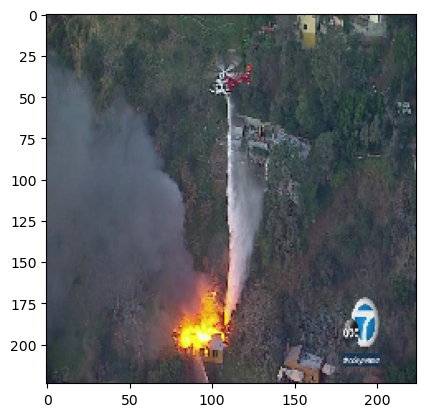

In [7]:
plt.imshow(img)
plt.plot()

In [8]:
img = (img / 256.)
img = np.expand_dims(img, axis=0)
print(img.shape)
img =np.transpose(img, (0, 3, 1, 2))
print(img.shape)

(1, 224, 224, 3)
(1, 3, 224, 224)


In [9]:
print(img.dtype)

float64


In [10]:
model_out = onnx_predict(img.astype(np.float32), detect_session)
#print(model_out)

In [11]:
pred_img = plot_predicted_img(img[0], model_out)

[0.40822928292410715, 0.8318219866071429, 0.139892578125, 0.205810546875, 0.64874267578125, 1.0]
[0.19959368024553573, 0.4959193638392857, 0.43121337890625, 0.755340576171875, 0.645355224609375, 0.0]
[0.5188380650111607, 0.15472848074776785, 0.08746337890625, 0.08447265625, 0.21429443359375, 1.0]


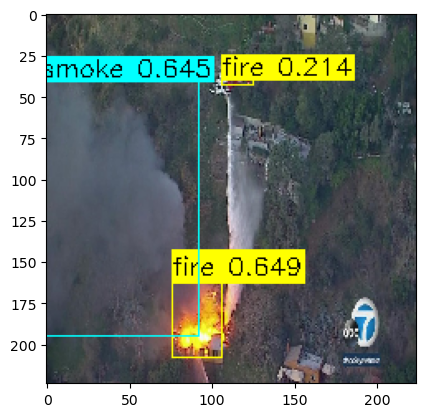

In [12]:
plt.imshow(pred_img)
plt.show()